# Homework 3: Text classification with Maximum Entropy model

Can we detect sarcasm in news article headlines?

In this homework, we will formulate a Maximum Entropy (MaxEnt) models to classify news headlines into sarcastic or not sarcastic.

## Bibliography

1. Misra, Rishabh and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019). https://arxiv.org/pdf/1908.07414.pdf
2. McCallum, Andrew, and Kamal Nigam. "A comparison of event models for naive bayes text classification." AAAI-98 workshop on learning for text categorization. Vol. 752. No. 1. 1998. http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.65.9324&rep=rep1&type=pdf
3. Kaggle dataset: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection

## News article headlines dataset

We will use the "Sarcasm headlines" dataset, collected by Ref. (1), and downloaded from Kaggle (3). The dataset consists of a series of headlines from news articles, classified as either being sarcastic, or not. The authors of (1) collected news from two sources: a serious news website (https://www.huffingtonpost.com), and an online newspaper that publishes satirical articles (https://www.theonion.com/). Headlines form the The Huffingtonpost were classified as non-sarcastic (`is_sarcastic=0`), and headlines from The Onion were classified as sarcastic (`is_sarcastic=1`).

**Data**. Two files have been prepared for this exercise: `train_data.json` containing the dataset that you will use to train the model, and `tests_data.json`, that you will use to evaluate the performance of the model. The following code will download these two data files for you.  

In [1]:
# Download the training and test datasets
train_url = "https://gist.github.com/cossio/5fa29aa95d629802e97cf16f8d6c86b9/raw/29106c1e0e230b6f19895914cadce13a9bcb7e1b/train_data.json"
tests_url = "https://gist.github.com/cossio/5fa29aa95d629802e97cf16f8d6c86b9/raw/29106c1e0e230b6f19895914cadce13a9bcb7e1b/tests_data.json"

import urllib.request
urllib.request.urlretrieve(train_url, "train_data.json")
urllib.request.urlretrieve(tests_url, "tests_data.json")

('tests_data.json', <http.client.HTTPMessage at 0x7fa24a3f5dc0>)

After downloading the data, you can use the following code to load and parse it.

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt

def parse_data(path):
    with open(path, 'r', encoding='utf-8') as file:
        for l in file:
            yield json.loads(l)

train_data = list(parse_data('train_data.json'))
tests_data = list(parse_data('tests_data.json'))
all_data = train_data + tests_data

#useful for some computations
train_data=np.array(train_data)
tests_data=np.array(tests_data)
all_data=np.array(all_data)

# Use less train data! (for Question 5)
#train_data, tests_data = all_data[:10000], all_data[10000:]

# print some examples
print('train data:')
for d in train_data[:3]:
    print(d)
print('tests data:')
for d in tests_data[:3]:
    print(d)

train data:
{'is_sarcastic': 0, 'headline': 'sónar festival offers more than you might expect', 'article_link': 'https://www.huffingtonpost.com/entry/sonar-festival-offers-mor_b_5507780.html'}
{'is_sarcastic': 1, 'headline': '2013 year in review photo essay shaping up to be quite horrific', 'article_link': 'https://www.theonion.com/2013-year-in-review-photo-essay-shaping-up-to-be-quite-1819575009'}
{'is_sarcastic': 1, 'headline': 'angolan war criminal called in as character witness to manafort fraud trial', 'article_link': 'https://politics.theonion.com/angolan-war-criminal-called-in-as-character-witness-to-1828084812'}
tests data:
{'is_sarcastic': 1, 'headline': "mother comes pretty close to using word 'streaming' correctly", 'article_link': 'https://www.theonion.com/mother-comes-pretty-close-to-using-word-streaming-cor-1819575546'}
{'is_sarcastic': 1, 'headline': 'shadow government getting too large to meet in marriott conference room b', 'article_link': 'https://politics.theonion.co

As you can see, each data point is a Python dictionary with three fields:

1. `'is_sarcastic'`, a binary value, equal to 1 if the headline is sarcastic, and equal to 0 otherwise.
2. `'headline'`, the news article headline.
3. `'article_link'`, a link to the original news article. Although in principle inspecting the news article itself can provide more information, in this tutorial we will **not** do this. For simplicity, please ignore the `'article_link'` field.

In [3]:
# number of train and testing data points
print(len(train_data))
print(len(tests_data))

22895
5724


In [4]:
len(train_data) / (len(train_data) + len(tests_data))

0.7999930116356266

In [5]:
# access 'headline' of the news article #6 from the training dataset
train_data[5]['headline']

'world will miss goal for universal education by 50 years: un'

To keep things simple, we will ``define'' a word as any portion of text delimited by spaces. The first thing we will do is to construct a list of all words encountered in all the datasets. We will then construct a dictionary giving the index of any word in this list.

In [6]:
# collect all words in a single list (set discards duplicates)
all_words = list(set(word for doc in all_data for word in doc['headline'].split()))
#.split is used to split the heading into a list of words

# total number of words
L = len(all_words)
print(L)

38234


In [7]:
# dictionary giving the index of a word in the list
word_index = {word: i for (i, word) in enumerate(all_words)}

In [8]:
# index of word 'expertise' in the list of all words
word_index['expertise']

3686

## Question 1

We represent a headline as a binary vector, $\vec\sigma=\{σ_i\}_{i=1}^L$, where $σ_i = 1$ if word $i$ appears in the headline, and $σ_i = 0$ otherwise. The vector $\vec\sigma$ is of length $L$, which equals the total number of words considered (the vocabulary, `all_words` in the code above).

**Q1a):** This representation of texts is missing important aspects of language. Can you give a simple argument for why?

*This representation doesn't take into account the structure of a sentence (ordering of the word etc.). Words, in principle, can have very different meaning depending on the context (i.e. neighboring words); this is true in particular for sarcastic phrases.*

We will formulate two maximum entropy models (one for each class) matching the empirical frequencies of words in the train dataset for each class. Let $c=0,1$ be our label ($c=1$ for sarcastic headlines, $c=0$ otherwise). For each word, we define its empirical frequency in headlines of class $c$ as follows:

$$p_i(c) = \frac{1}{M_c}\sum_{\vec\sigma\in\mathcal D_c}\sigma_i$$

where $\mathcal D_c$ is the set of headlines of class $c$, and $M_c=|\mathcal D_c|$ is their number in our dataset. Notice that if a word appears more than once in a headline, it will still be counted as one. Since some rare words occur very few times in the data, it is recommended to add a *pseudo-count*,

$$p_i(c) = \frac{1}{M_c+1}\left(\sum_{\vec\sigma\in\mathcal D_c}\sigma_i + 1\right)$$

This avoids unintentional divisions by zero below. This procedure will be better justified in the following lectures when we discuss the role of the prior distribution.

As shown in the lecture, the MaxEnt model matching these empirical frequencies for each class, is of the form:

$$P(\vec{\sigma}|c) = \frac{e^{\sum_i h_i(c)\sigma_i}}{Z(c)}$$

where

$$Z (c) = \sum_{\vec{\sigma}}e^{\sum_i h_i (c) \sigma_i} = \prod_i
\sum_{\sigma=0,1}e^{h_i (c) \sigma_i} = \prod_i (1 + e^{h_i (c)})$$

and the fields $h_i(c)$ are such that the moment-matching constraints are satisfied.

**Q1b)** Write the expression of the fields $h_i(c)$ to satisfy the moment-matching constraints $\langle \sigma_i \rangle_c = p_i(c)$, where $\langle . \rangle_c$ indicates the expectations under the model.

*Since the model doesn't take structure into account: $<\vec{\sigma}>_c=\prod_i <\sigma_i>_c$, where $<\sigma_i>_c= Tr   \ \sigma_i P(\sigma_i|c) \stackrel{!}{=} p_i(c)$. Hence, one finds: $$h_i(c)=\log\left(\frac{p_i(c)}{1-p_i(c)}\right)$$*

**Q1c)** Estimate the fields $h_i(c)$ for all the words in the full dataset, but using only the training data to estimate the empirical frequencies $p_i(c)$ (use the pseudocount, as explained above). Explain why the pseudo-count is necessary. *Hint: Consider a word that occurs in the testset, but not in the training set.*

*A problem is that rare words could appear only in the headline of a particular class (sarcastic or not), giving $p_j(c)\neq 0$, but that might not appear in the complementary class: $p_j(\bar{c})=0$. Which is unlikely, not impossible, that just based on a single word we are able to determine the class of an headline.
But the real problem raises if we note that $\vec{p}(c)$ is built only starting from the training data. Hence, a rare word might appear only on the test set, but not on the training set. Since this is due to the fact that we have a finite number of data samples, it is more sensible (or at least less restrictive) to do a pseudo-counting where we associate to those problematic words a very low frequency. This allows the expression for $h_i(c)$ stated above, to be finite for any word.*

In [9]:
#let's build the sigmas
def get_sigma(sample):
    words=sample['headline'].split()
    idxs=[word_index[word] for word in words]
    sigma=np.zeros(len(all_words))
    sigma[idxs]=1
    return sigma

def get_sigma_set(dataset):
    sigma_set_sarc=[]
    sigma_set_nonsarc=[]
    for sample in dataset:
        if sample['is_sarcastic']==1:
            sigma_set_sarc.append(get_sigma(sample))
        else:
            sigma_set_nonsarc.append(get_sigma(sample))
    return sigma_set_sarc, sigma_set_nonsarc

In [10]:
def pseudo_counter(word_idx, D_c):
    occ=0
    for i in range(len(D_c)):
            occ += D_c[i][word_idx]
    return 1/(len(D_c)+1) * (occ + 1)

def p_builder(D_c):
    p=[]
    for idx in np.arange(word_index[all_words[-1]]+1):
        p.append(pseudo_counter(idx, D_c))
    return p

def get_h(p):
    return np.log(p/(np.ones(len(p))-p))

In [11]:
train_D_1, train_D_0 = get_sigma_set(train_data)
p_0 = p_builder(train_D_0)
p_1 = p_builder(train_D_1)
h_c=[get_h(p_0), get_h(p_1)]

## Question 2.

**Q2a)** Plot the histogram of $\log P(\vec\sigma|c=1)$ for the sarcastic headlines, and for the serious headlines (in the same plot), for the test dataset. Are the histograms different?


In [12]:
def log_part_func(h):
    return np.sum(np.log(1+np.exp(h)))
        

def get_log_P_sigma_cond_c(sigma_set, h, c):
    P_sigma_cond_c_set=[]
    for sigma in sigma_set:
        P_sigma_cond_c_set.append(np.dot(h[c],sigma))
    return P_sigma_cond_c_set - log_part_func(h[c])

In [13]:
sigma_set_sarc, sigma_set_nonsarc = get_sigma_set(tests_data)
P_sigma_sarc_cond_1 = get_log_P_sigma_cond_c(sigma_set_sarc, h_c, c=1)
P_sigma_nonsarc_cond_1 = get_log_P_sigma_cond_c(sigma_set_nonsarc, h_c, c=1)
P_sigma_sarc_cond_0 = get_log_P_sigma_cond_c(sigma_set_sarc, h_c, c=0)
P_sigma_nonsarc_cond_0 = get_log_P_sigma_cond_c(sigma_set_nonsarc, h_c, c=0)

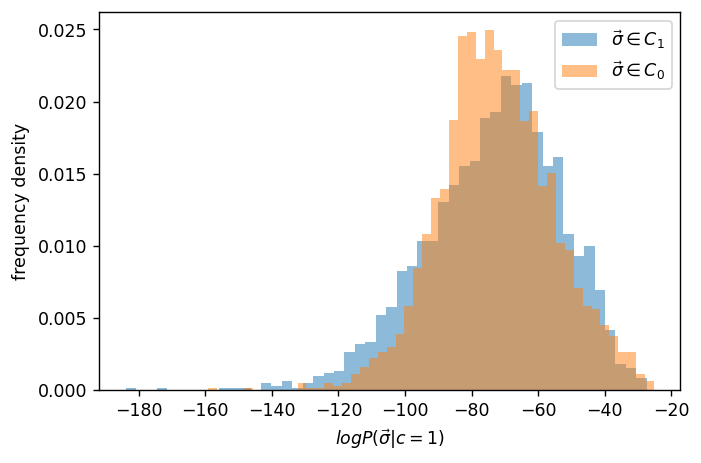

In [14]:
nbins=50
plt.figure(dpi=125)
plt.hist(P_sigma_sarc_cond_1, bins=nbins, alpha=0.5, density=True, label="$\\vec{\sigma} \in C_1$")
plt.hist(P_sigma_nonsarc_cond_1, bins=nbins, alpha=0.5, density=True, label="$\\vec{\sigma} \in C_0$")
plt.ylabel("frequency density")
plt.xlabel("$log P(\\vec{\sigma}|c=1)$")
plt.legend()
plt.show()

*As shown in the plot the two distributions are not very different.* EXPLAIN MORE

In [15]:
#point c relative to point a:
nbins=50
px, xedges=np.histogram(P_sigma_sarc_cond_1, bins=nbins,  density=True)
py, yedges=np.histogram(P_sigma_nonsarc_cond_1, bins=nbins,  density=True)
x_mid = (xedges[:-1]+xedges[1:])/2
y_mid= (yedges[:-1]+yedges[1:])/2
dx=x_mid[1]-x_mid[0]
dy=y_mid[1]-y_mid[0]
x_mean=np.dot(x_mid, px)*dx
y_mean=np.dot(y_mid, py)*dy
x_var=np.dot(x_mid**2, px)*dx
y_var=np.dot(y_mid**2, py)*dy
dev= np.abs(x_mean-y_mean)/(np.power(x_var*y_var, 0.25))
print("normalized difference in means:", dev)


normalized difference in means: 0.01051734327780851


**Bonus:** Same as b), but for $\log P(\vec\sigma|c=0)$. (I guess a) was meant, otherwise I don't understand the question)


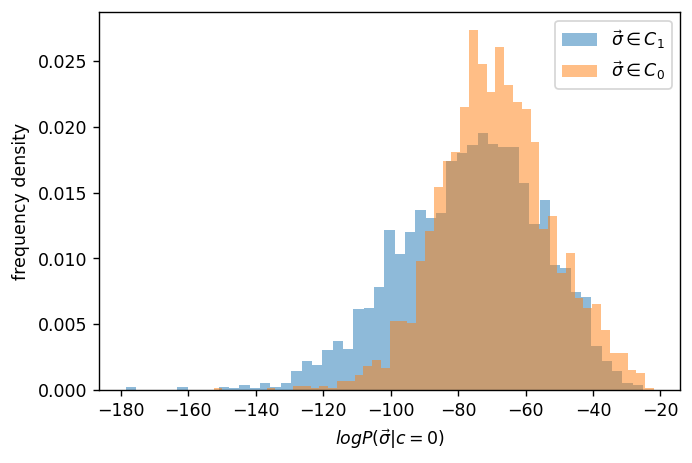

In [16]:
nbins=50
plt.figure(dpi=125)
plt.hist(P_sigma_sarc_cond_0, bins=nbins, alpha=0.5, density=True, label="$\\vec{\sigma} \in C_1$")
plt.hist(P_sigma_nonsarc_cond_0, bins=nbins, alpha=0.5, density=True, label="$\\vec{\sigma} \in C_0$")
plt.ylabel("frequency density")
plt.xlabel("$log P(\\vec{\sigma}|c=0)$")
plt.legend()
plt.show()

In [17]:
#point c relative to bonus
nbins=50
px, xedges=np.histogram(P_sigma_sarc_cond_0, bins=nbins,  density=True)
py, yedges=np.histogram(P_sigma_nonsarc_cond_0, bins=nbins,  density=True)
x_mid = (xedges[:-1]+xedges[1:])/2
y_mid= (yedges[:-1]+yedges[1:])/2
dx=x_mid[1]-x_mid[0]
dy=y_mid[1]-y_mid[0]
x_mean=np.dot(x_mid, px)*dx
y_mean=np.dot(y_mid, py)*dy
x_var=np.dot(x_mid**2, px)*dx
y_var=np.dot(y_mid**2, py)*dy
dev= np.abs(x_mean-y_mean)/(np.power(x_var*y_var, 0.25))
print("normalized difference in means:", dev)

normalized difference in means: 0.10133404959258022


**Q2b)** Plot the histogram of $\log\frac{P(\vec\sigma|c=1)}{P(\vec\sigma|c=0)}$ for the sarcastic headlines, and for the serious headlines. Are the histograms different?




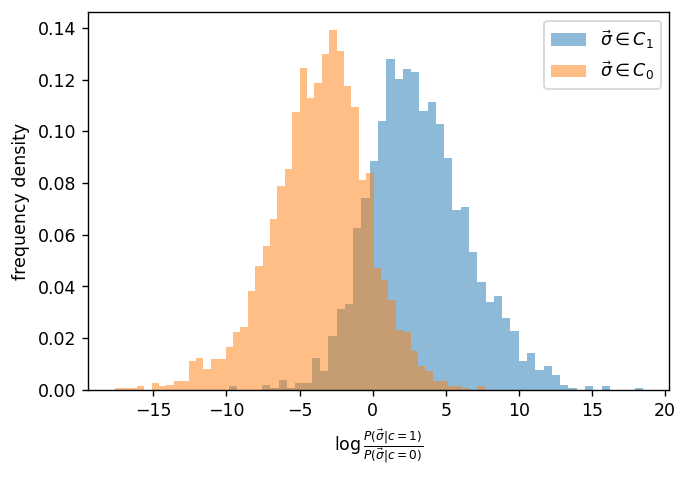

In [18]:
nbins=50
plt.figure(dpi=125)
plt.hist(P_sigma_sarc_cond_1-P_sigma_sarc_cond_0, bins=nbins, alpha=0.5, density=True, label="$\\vec{\sigma} \in C_1$")
plt.hist(P_sigma_nonsarc_cond_1-P_sigma_nonsarc_cond_0, bins=nbins, alpha=0.5, density=True, label="$\\vec{\sigma} \in C_0$")
plt.ylabel("frequency density")
plt.xlabel("$\log\\frac{P(\\vec{\sigma}|c=1)}{P(\\vec{\sigma}|c=0)}$")
plt.legend()
plt.show()


*The histograms have very different peaks and very similar variance. And a good part of the two distributions overlaps.*

In [19]:
#point c relative to point b:
nbins=50
px, xedges=np.histogram(P_sigma_sarc_cond_1-P_sigma_sarc_cond_0, bins=nbins,  density=True)
py, yedges=np.histogram(P_sigma_nonsarc_cond_1-P_sigma_nonsarc_cond_0, bins=nbins,  density=True)
x_mid = (xedges[:-1]+xedges[1:])/2
y_mid= (yedges[:-1]+yedges[1:])/2
dx=x_mid[1]-x_mid[0]
dy=y_mid[1]-y_mid[0]
x_mean=np.dot(x_mid, px)*dx
y_mean=np.dot(y_mid, py)*dy
x_var=np.dot(x_mid**2, px)*dx
y_var=np.dot(y_mid**2, py)*dy
dev= np.abs(x_mean-y_mean)/(np.power(x_var*y_var, 0.25))
print("normalized difference in means:", dev)


normalized difference in means: 1.433019028750203



**Q2c)** To give a quantitative measure of the separation of the two histograms above, you can compute the difference in means, normalized by the geometric mean of their standard deviations:

$$\frac{|\langle x\rangle - \langle y\rangle|}{\sqrt{\sigma_x \sigma_y}}$$

where $x,y$ denote the two kind of log-likelihoods or log-likelihood differences, considered in a), b).

In [20]:
#just look after point a and point b.

### Question 3

**Q3a)** Using Bayes theorem, compute the ratio $P(c=1|\vec{\sigma})/P(c=0|\vec{\sigma})$ for the headlines in your testing set (note that $P(\vec{\sigma})$ cancels). To obtain an empirical estimate of $P(c)$, you can count the number of headlines in each class of the training set. Your classifier will use these ratios as the scores to predict the label of a headline.

*Using bayes theorem one gets: $$ \frac{P(c=1|\vec{\sigma})}{P(c=0|\vec{\sigma})}=\frac{P(\vec{\sigma}|c=1)P(c=1)}{P(\vec{\sigma}|c=0)P(c=0)}$$*

*Our prior is: $P(c=1)=\frac{\text{\# sarcastic training samples}}{\text{\# tot training samples}}$ and $P(c=0)=1-P(c=1)$*

In [21]:
#find prior (use train data):
train_data_labels=[train_data[i]['is_sarcastic'] for i in range(len(train_data))]
Prior_1=np.sum(train_data_labels)/len(train_data_labels)
Prior_0=1-Prior_1
Prior_ratio= Prior_1/Prior_0

#partition functions
log_Z_ratio = log_part_func(h_c[0]) - log_part_func(h_c[1])

#Posterior ratio:
def Post_ratio(sample):
    sigma=get_sigma(sample)
    log_likelihood_ratio=np.dot(sigma, h_c[1]-h_c[0]) + log_Z_ratio
    log_post= Prior_ratio * (np.exp(log_likelihood_ratio))
    return log_post

# apply on testing set

post_ratio_test=[]
predicted_labels=[]
for sample in tests_data:
    post_ratio_test.append(Post_ratio(sample))
    predicted_labels.append(post_ratio_test[-1]>1)

predicted_labels=np.array(predicted_labels, dtype=int)

#true labels
true_test_labels=[tests_data[i]['is_sarcastic'] for i in range(len(tests_data))]

**Q3b)** How accurate is this classifier? To quantify this, plot the Receiver Operating Characteristic Curve (ROC) and compute the Area Under the Curve (AUC). See Appendix for an explanation of the ROC and the AUC. *Hint: The ROC curve is easier to obtain if you assume that the scores are sorted. You can also use the functions `roc_curve` and `auc` from the python package `sklearn`.*

**Bonus:** What is the ROC curve and AUC of a random classifier (that emits random labels for each headline)? What is the ROC curve and AUC of a perfect classifier (that emits the correct label for every headline)?

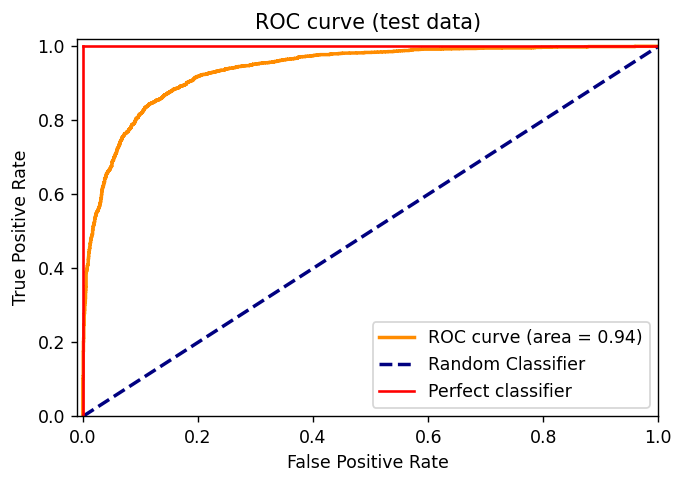

In [22]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_true=true_test_labels, y_score=post_ratio_test)
roc_auc = auc(fpr, tpr)
plt.figure(dpi=125)
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--", label="Random Classifier")

plt.plot([0, 0], [1, 0],c="red")
plt.plot([1, 0], [1, 1],c="red", label="Perfect classifier")

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (test data)")
plt.legend(loc="lower right")
plt.show()

**Bonus:** Describe the connection between the areas under the histogram  curves of exercise 2 from b) and the AUC.

*Looking at point 2b, if there was no overlap between the two histograms, our predictor would be a perfect classifier. Being there some overlap, which is only partial, we see that our predictor isn't perfect but yet it is a good predictor because the two histograms are quite distinct. Moreover, the point where the two curves meet is roughly when the log of the likelihood ratio is 0, i.e. when the likelihood ratio is 1.*

**(BONUS) Q3c)** Estimate the mutual information between the headline and the label,

$$MI(\vec\sigma,c)=\sum_{\vec\sigma,c}P(\vec\sigma,c)\ln\left(\frac{P(\vec\sigma,c)}{P(\vec\sigma)P(c)}\right)$$

Using the exact expression is intractable. However, you can obtain a practical estimate by approximating the outer average over the model distribution $P(\vec\sigma,c)$, with an empirical average over your data,

$$MI(\vec\sigma,c)\approx\frac{1}{M}\sum_d\ln\left(\frac{P(\vec\sigma_d,c_d)}{P(\vec\sigma_d)P(c_d)}\right)$$

where the sum over $d$ goes over the labeled headlines $\vec\sigma_d,c_d$ of your dataset. Estimate $MI(\vec\sigma,c)$ using this approximate expression for your training set and your testing set.

### Question 4

Compute the Kullback-Leiber (KL) divergences between the 2 models,

$$D_{KL}(P(\vec\sigma|c=0) || P(\vec\sigma|c=1))$$

and

$$D_{KL}(P(\vec\sigma|c=1) || P(\vec\sigma|c=0))$$

Why are the two KL divergences different?

In [23]:
#using the expression of point 4a (next point):

D_KL_0_1 = np.dot(p_0, (h_c[0]-h_c[1])) - (log_part_func(h_c[0]) - log_part_func(h_c[1]))
D_KL_1_0 = np.dot(p_1, (h_c[1]-h_c[0])) + (log_part_func(h_c[0]) - log_part_func(h_c[1]))

print("D( P(sigma|c=0) || P(sigma|c=1) ) = ", D_KL_0_1)
print("D( P(sigma|c=1) || P(sigma|c=0) ) = ", D_KL_1_0)

D( P(sigma|c=0) || P(sigma|c=1) ) =  4.748140242747965
D( P(sigma|c=1) || P(sigma|c=0) ) =  4.964837086828955


*In general the KL divergence isn't symmetric, so it is not a big surprise that they're not exacly the same, but they still take similar values.*



**Q4a)** Show that the KL divergences above, are sums of contributions for each word. Derive analytical expressions, as functions of the fields $h_i(c)$ in each case.


![](IMG_F9A195849BD5-1.jpeg)

**Q4b)** Consider the task of classifying a newspaper as publishing sarcastic or non-sarcastic news articles. Estimate (approximatey) how many headlines your model will need to guess the correct classification confidently (with a probability of error below $10^{-10}$), assuming that in reality, i) the news-source publishes sarcastic headlines, or ii) the news-source publishes serious articles.

![](IMG_1196.jpg)

In [24]:
eps=10**-10
M_0=-np.log(eps)/D_KL_0_1
M_1=-np.log(eps)/D_KL_1_0
print("sarcastic samples required: ", M_1)
print("non sarcastic samples required: ", M_0)

sarcastic samples required:  4.637785797851241
non sarcastic samples required:  4.849446257428645


*We get that 5 papers are enough in both cases, but this isn't consistent with the CLT approximation done in the calculation... I don't know how to explain this.*

**Q4c)** To model different newspapers, construct datasets $D_1(c=1), D_2(c=1), \dots, D_{10}(c=1)$ consisting of different numbers of sarcastic headlines only, by taking the first 5, 10, 15, ..., 50, sarcastic headlines from the test dataset. Similarly, construct datasets $D_1(c=0), D_2(c=0), \dots, D_{10}(c=0)$ consisting of serious headlines only, by taking the first 5, 10, 15, .. 50 serious headlines from the test dataset. Compute the log-likelihood of each of these datasets under the two models $P(\vec\sigma|c=0,1)$.

In [25]:
test_D_1, test_D_0 = get_sigma_set(tests_data)
test_D_0=np.expand_dims(test_D_0,axis=1)
test_D_1=np.expand_dims(test_D_1,axis=1)

sizes=5*np.arange(1,11)
log_likelihood_0_true_0=[]
log_likelihood_0_true_1=[]
log_likelihood_1_true_0=[]
log_likelihood_1_true_1=[]


for size in sizes:
    idx0 = np.random.choice(np.arange(len(test_D_0)), size=size, replace=False)
    idx1 = np.random.choice(np.arange(len(test_D_1)), size=size, replace=False)
    D_0 = test_D_0[idx0,:]
    D_1 = test_D_1[idx1,:] 

    temp_0_true_0=0
    temp_0_true_1=0
    temp_1_true_1=0
    temp_1_true_0=0
    for i in range(size):
         temp_0_true_0+= np.dot(D_0[i], h_c[0]) - log_part_func(h_c[0])
         temp_0_true_1+= np.dot(D_1[i], h_c[0]) - log_part_func(h_c[0])
         temp_1_true_1+= np.dot(D_1[i], h_c[1]) - log_part_func(h_c[1])
         temp_1_true_0+= np.dot(D_0[i], h_c[1]) - log_part_func(h_c[1])
    log_likelihood_0_true_0.append(temp_0_true_0)
    log_likelihood_0_true_1.append(temp_0_true_1)
    log_likelihood_1_true_0.append(temp_1_true_0)
    log_likelihood_1_true_1.append(temp_1_true_1)

log_likelihood_0_true_0=np.array(log_likelihood_0_true_0)
log_likelihood_0_true_1=np.array(log_likelihood_0_true_1)
log_likelihood_1_true_0=np.array(log_likelihood_1_true_0)
log_likelihood_1_true_1=np.array(log_likelihood_1_true_1)


**Q4d)** Plot the log-likelihood difference versus the number of headlines in each of the datasets constructed in Q4c). What is the expected slope of this plot?

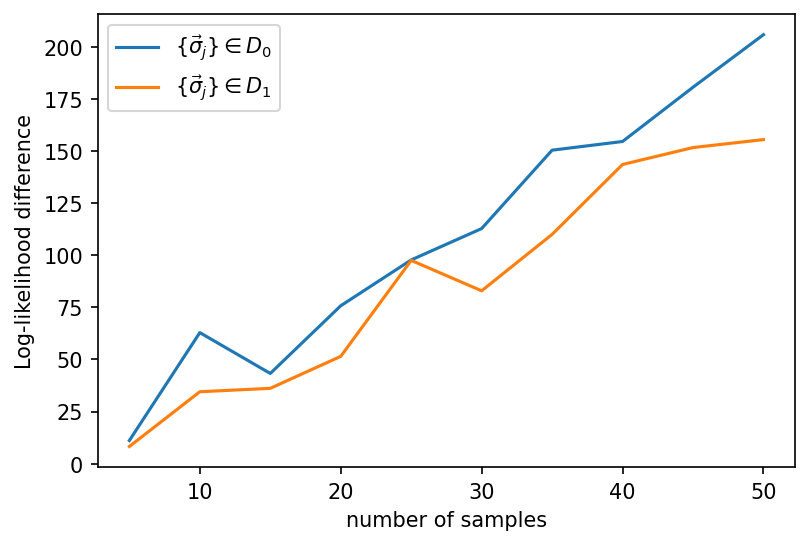

In [26]:
plt.figure(dpi=150)
plt.plot(sizes, (log_likelihood_0_true_0-log_likelihood_1_true_0), label="$ \{ \\vec{\sigma}_j \} \in D_0$")
plt.plot(sizes, (log_likelihood_1_true_1-log_likelihood_0_true_1), label="$\{ \\vec{\sigma}_j\} \in D_1$")
plt.xlabel("number of samples")
plt.ylabel("Log-likelihood difference")
plt.legend()
plt.show()

*The slope is given by the KL divergence.*



**Q4e)** Plot the log-likelihood difference per headlines (i.e., divided by number of headlines), versus the number of headlines in each of the datasets constructed in c). What is the expected asymptotic of this plot?

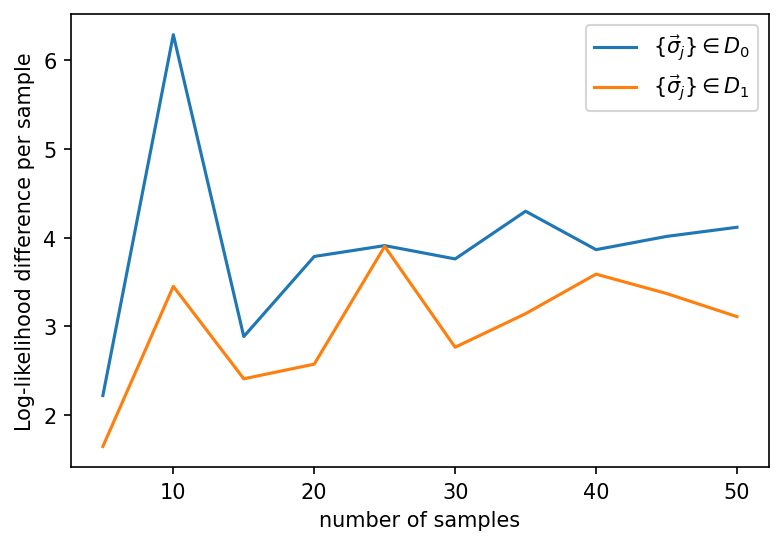

In [27]:
sizes=np.reshape(sizes, (10,1))
plt.figure(dpi=150)
plt.plot(sizes, (log_likelihood_0_true_0-log_likelihood_1_true_0)/sizes, label="$ \{ \\vec{\sigma}_j \} \in D_0$")
plt.plot(sizes, (log_likelihood_1_true_1-log_likelihood_0_true_1)/sizes, label="$\{ \\vec{\sigma}_j\} \in D_1$")
plt.xlabel("number of samples")
plt.ylabel("Log-likelihood difference per sample")
plt.legend()
plt.show()

*The asymptotic value should be again the KL divergence*

## Question 5

In the previous exercises, your training dataset contained $\approx 80\%$ of headlines in your entire dataset. Repeat exericses 1-4, but reducing your training dataset to only the first 100, 1000, and 10000 headlines, assigning all the remaining headlines to the testing set. Discuss the impact on the performance of the model of the limited training data. Plot the AUC for the different sizes of training data, and the score computed in Q2c. *Hint: You can just modify the definition of `train_data` in the first cell of this notebook and re-run everything else!*

In [28]:
train_size=(100,1000,10000)
score_1=[0.00142238610706922,  0.01304506737030673, 0.019660008023236156]
score_2=[0.06356222855674803,  0.8489561392982874, 1.3831232548057368]
auc_collection=[0.7604624992341471, 0.8394454912608785, 0.92232246355003]


Text(0.5, 0, 'train set size')

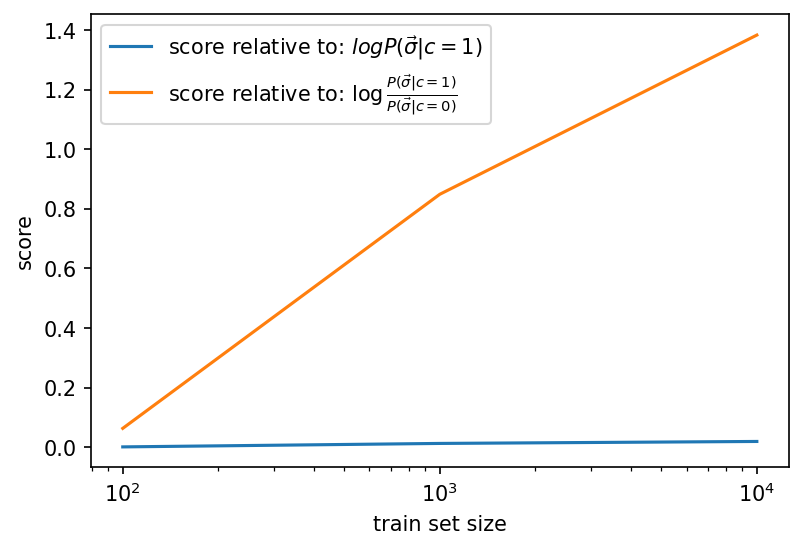

In [29]:
plt.figure(dpi=150)
plt.plot(train_size, score_1, label= "score relative to: $log P(\\vec{\sigma}|c=1)$")
plt.plot(train_size, score_2, label="score relative to: $\log\\frac{P(\\vec{\sigma}|c=1)}{P(\\vec{\sigma}|c=0)}$")
plt.xscale('log')
plt.legend()
plt.plot()
plt.ylabel("score")
plt.xlabel("train set size")

Text(0, 0.5, 'AUC')

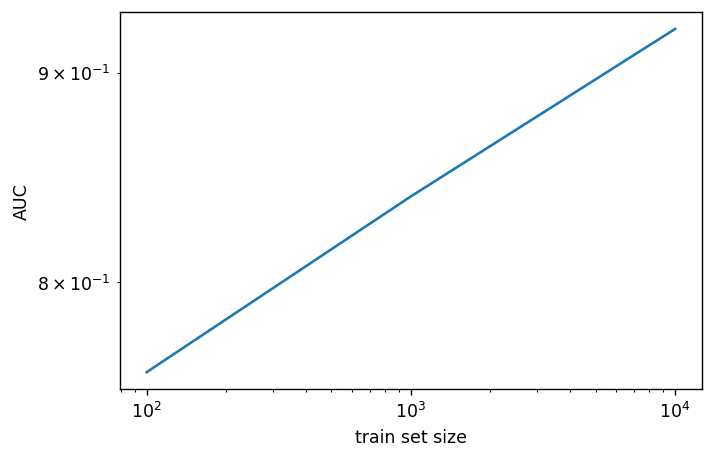

In [30]:
plt.figure(dpi=125)
plt.plot(train_size, auc_collection)
plt.yscale('log')
plt.xscale('log')
plt.xlabel("train set size")
plt.ylabel("AUC")

The performance of the model grows logarithmically with the size of the training dataset.

![](ROC.png)

The three curves are relative to the train sizes 100, 1000, 10000

# Appendix: ROC and AUC

Giving predicted scores $S_i$ (in the exercises above you will use the odds ratio $P(c=1|\vec\sigma)/P(c=0|\vec\sigma)$ of the headlines $\vec\sigma_i$, and their true labels, $y_i=0,1$, we consider a threshold $t$ and assume that headlines for which $S_i > t$ are predicted to be sarcastic, while those for which $S_i\le t$ are predicted to be non-sarcastic. We define:

$$TP(t) = \text{number of true positives}\quad
(S_i > t\, \text{and}\, y_i=1)$$
$$FP(t) = \text{number of false positives}\quad
(S_i > t\, \text{and}\, y_i=0)$$

That is, $TP(t)$ is the number of correctly classified positive (sarcastic) headlines, and $FP(t)$ is the number of wrongly classified negative (non-sarcastic) headlines. In addition, let $P$ be the total number of sarcastic headlines in the data, and $N$ the total number of non-sarcastic headlines. Finally we define:

$$TPR(t) = \frac{TP(t)}{P} ,\qquad FPR(t) = \frac{FP(t)}{N}$$

The ROC curve is defined as the parametric curve $(FPR(t), TPR(t))$, traversed as the threshold takes all possible values, $-\infty<t<\infty$. Notice that $0\le TPR(t)\le1$ and $0\le FPR(t)\le1$, and that:

$TPR(-\infty)=FPR(-\infty)=1,\qquad TPR(\infty)=FPR(\infty)=0$.

The AUC is defined as the area under this curve:

$$AUC = \int_{t=-\infty}^\infty TPR(t) \times \mathrm d FPR(t)
= \int_{t=-\infty}^\infty TPR(t) \times \frac{\mathrm d FPR(t)}{\mathrm d t} \mathrm{d}t$$


---